In [1]:
import csv
import numpy as np

In [2]:
with open('input.csv', 'r') as csvfile:
    inputs = list(csv.reader(csvfile))
    inputs = [
        [float(num) for num in row]
        for row in inputs
        if '-999' not in row
    ]
inputs = np.array(inputs)

with open('output.csv', 'r') as csvfile:
    outputs = list(csv.reader(csvfile)) #[1:] # Skip the first row
    outputs = [
        [float(num) for num in row]
        for row in outputs
    ]
outputs = np.array(outputs)

Get the depths with output values

In [3]:
# Output depths
out_depths = outputs[:,0]
out_depths = [round(depth, 1) for depth in out_depths]

# Input depths
in_depths = inputs[:,0]
in_depths = [round(depth, 1) for depth in in_depths]

In [4]:
X = []
Y = []

# inputs = inputs[:,1:] #remove the first redundant column
# Map output values to inputs
for out_idx, depth in enumerate(out_depths):
    if depth in in_depths:
        # Map the inputs to outputs by depth
        X.append(inputs[in_depths.index(depth)])
        Y.append(outputs[out_idx][1])
X = np.array(X)
Y = np.array(Y)

Scale inputs so that mean = 0 / variance = 1

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

input_scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
input_scaler.fit(inputs)
output_scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
output_scaler.fit(outputs[:,-1].reshape(-1, 1))

X = input_scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1994)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
# Y_scaled = output_scaler.transform(Y.reshape(-1, 1))

(189, 5)
(189,)
(48, 5)
(48,)


Naive model in scikit-learn for testing model parameters

In [6]:
# from sklearn.neural_network import MLPRegressor

# models = []
# for hidden_size in range(10, 210, 10):
#     for lr in [0.1, 0.01, 0.001]:
#         for alpha in [0.05, 0.1, 0.25, 0.5]:
#             model = MLPRegressor(hidden_layer_sizes=(hidden_size,), 
#                                  activation='relu', 
#                                  solver='lbfgs',
#                                  alpha=alpha,
#                                  max_iter=500,
#                                  learning_rate_init=lr,
#                                  validation_fraction=0.1,
#                                  random_state=1994,
#                                  verbose=False)
#             model.fit(X, Y)
#             score = model.score(X,Y)
#             print('Testing with hidden_size=%s, lr=%s, alpha:%s, score:%s' % (hidden_size, lr, alpha, score))
#             models.append({'model': model, 'score': score})

In [7]:
# Best score
# models = sorted(models, key=lambda x:-x['score'])
# top_model = models[0]['model']
# print(top_model)

# From this we found out that best model has alpha=0.05; hidden_size=170; lr=0.1
# MLPRegressor(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
#        beta_2=0.999, early_stopping=False, epsilon=1e-08,
#        hidden_layer_sizes=(170,), learning_rate='constant',
#        learning_rate_init=0.1, max_iter=500, momentum=0.9,
#        nesterovs_momentum=True, power_t=0.5, random_state=1994,
#        shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
#        verbose=False, warm_start=False)

In [8]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=(170,), 
                     activation='relu', 
                     solver='lbfgs',
                     alpha=0.05,
                     max_iter=500,
                     learning_rate_init=0.1,
                     validation_fraction=0.,
                     random_state=1994,
                     verbose=False)
model.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(170,), learning_rate='constant',
       learning_rate_init=0.1, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1994,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.0,
       verbose=False, warm_start=False)

In [9]:
# print(Y)

In [10]:
# print(model.predict(X))

Calculate R^2 score of the model

In [11]:
model.score(X_test, y_test)

-2.386993342313885

More flexible model with ELU instead of ReLU

In [12]:
import torch
Y_view = np.reshape(y_train, (-1, 1)) # Transform Y into 2d array

from torch.autograd import Variable
X_var = Variable(torch.from_numpy(X_train).float())
Y_var = Variable(torch.from_numpy(Y_view).float())

In [13]:
import torch.nn as nn

class Simple_NN(nn.Module):
    
    def __init__(self, config):
        super(Simple_NN, self).__init__()
        
        self.hidden_size = config['hidden_size']
        self.dropout_keep_prob = config['dropout_keep_prob']
        
        self.linear = nn.Sequential(
            nn.Linear(5, self.hidden_size),
            nn.ELU(),
            nn.Dropout(1 - self.dropout_keep_prob),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ELU(),
            nn.Dropout(1 - self.dropout_keep_prob),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ELU(),
            nn.Dropout(1 - self.dropout_keep_prob),
            nn.Linear(self.hidden_size, 1),
        )
        
    def forward(self, inputs):
        output = self.linear(inputs)
        return output

In [14]:
import torch.optim as optim
from sklearn.metrics import r2_score

models = []
for hidden_size in range(10, 200, 10):
    for lr in [0.1, 0.01, 0.001]:
        for dropout in [0.9, 0.8, 0.7, 0.6, 0.5]:
            # Training:
            all_losses = []

            model = Simple_NN({'hidden_size': hidden_size, 'dropout_keep_prob': dropout})
            # optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
            optimizer = optim.Adam(model.parameters(), lr=lr)
            criterion = nn.SmoothL1Loss()

            for epoch in range(1000):
                optimizer.zero_grad()

                output = model(X_var)
                loss = criterion(output, Y_var)
                loss.backward()

                nn.utils.clip_grad_norm(model.parameters(), 5.)
                all_losses.append(loss.data[0])

            #     print('Epoch %s, loss: %s' % (epoch + 1, loss.data[0]))

                optimizer.step()

            output_pred = model(Variable(torch.from_numpy(X_test).float()))
            output_pred = output_pred.data.numpy()

            # Calculate R2 of the pytorch model
            score = r2_score(y_test, output_pred)
            
            print('Hidden size: %s, Score: %s' % (hidden_size, score))
            
            models.append({
                'model': model, 
                'score': score, 
                'losses': all_losses, 
                'hidden_size': hidden_size, 
                'lr': lr, 
                'dropout_keep': dropout
            })

Hidden size: 10, Score: 0.04292283849399281
Hidden size: 10, Score: 0.15314582219050932
Hidden size: 10, Score: 0.024277574558904225
Hidden size: 10, Score: 0.04486125054394541
Hidden size: 10, Score: -0.050650000471530676
Hidden size: 10, Score: 0.07833279978330221
Hidden size: 10, Score: -0.0755791824369163
Hidden size: 10, Score: 0.09728055036726158
Hidden size: 10, Score: 0.16572045544986336
Hidden size: 10, Score: 0.047247755917771195
Hidden size: 10, Score: 0.035395430401096384
Hidden size: 10, Score: -0.04386662058421398
Hidden size: 10, Score: -0.12452903481626709
Hidden size: 10, Score: -0.086046684724574
Hidden size: 10, Score: -0.3084646123313355
Hidden size: 20, Score: 0.04533051866066029
Hidden size: 20, Score: 0.07852650455659749
Hidden size: 20, Score: -0.07096032143656883
Hidden size: 20, Score: -1.1973143026248843
Hidden size: 20, Score: -0.9634174906973221
Hidden size: 20, Score: -0.2342330387698599
Hidden size: 20, Score: -0.1345054157238723
Hidden size: 20, Score: 0

Hidden size: 130, Score: 0.10034815302081301
Hidden size: 130, Score: -0.43435438477800536
Hidden size: 130, Score: -0.190814703066164
Hidden size: 130, Score: -0.10686123997453967
Hidden size: 130, Score: 0.002729023370818595
Hidden size: 130, Score: -0.1780219982926805
Hidden size: 130, Score: 0.06478788823187431
Hidden size: 130, Score: 0.06363662709155671
Hidden size: 130, Score: 0.05532662043019154
Hidden size: 130, Score: 0.03268642609299177
Hidden size: 130, Score: 0.15623037577101906
Hidden size: 140, Score: -0.09448244723994326
Hidden size: 140, Score: -0.23754230112735608
Hidden size: 140, Score: -0.6044021802594735
Hidden size: 140, Score: -0.09797918297977537
Hidden size: 140, Score: -0.10155382522110057
Hidden size: 140, Score: -0.01736040986146037
Hidden size: 140, Score: -0.22934942822467996
Hidden size: 140, Score: -0.6392891520003359
Hidden size: 140, Score: 0.296961145752237
Hidden size: 140, Score: -0.07019738102215611
Hidden size: 140, Score: 0.2293306374050933
Hidd

In [20]:
# Best score
models = sorted(models, key=lambda x:-x['score'])
top_model = models[0]['model']
print(top_model)
print(models[0]['score'])

Simple_NN(
  (linear): Sequential(
    (0): Linear(in_features=5, out_features=190, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.5)
    (3): Linear(in_features=190, out_features=190, bias=True)
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.5)
    (6): Linear(in_features=190, out_features=190, bias=True)
    (7): ELU(alpha=1.0)
    (8): Dropout(p=0.5)
    (9): Linear(in_features=190, out_features=1, bias=True)
  )
)
0.3007091979501415


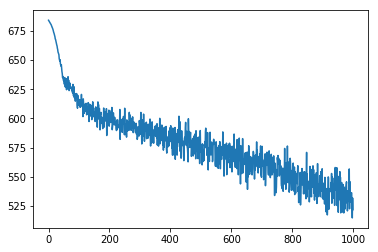

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(models[0]['losses'])
plt.show()

In [22]:
output_pred = top_model(Variable(torch.from_numpy(X_test).float()))

In [23]:
# Convert back to numpy
output_pred = output_pred.data.numpy()
print(output_pred)

[[ 7.58976440e+02]
 [ 5.75979309e+02]
 [ 7.69914185e+02]
 [ 2.18642059e+02]
 [ 6.22408569e+02]
 [ 8.05419617e+02]
 [ 5.04340179e+02]
 [ 8.81894653e+02]
 [ 3.47491058e+02]
 [ 6.83891663e+02]
 [ 1.23302078e+02]
 [ 7.85998474e+02]
 [ 2.48467278e+00]
 [-1.29189754e+00]
 [ 1.69420447e+03]
 [ 5.05795380e+02]
 [ 7.06547913e+02]
 [ 5.46343323e+02]
 [ 9.22939453e+01]
 [ 6.40608549e+00]
 [ 2.04242992e+00]
 [ 4.96196823e+01]
 [ 3.11699158e+02]
 [ 6.60251760e+00]
 [ 1.03307486e-01]
 [ 8.35807495e+02]
 [ 1.99972336e+02]
 [ 2.50072718e+00]
 [ 8.27781856e-01]
 [ 9.65916348e+00]
 [ 1.43242908e+00]
 [ 3.18187897e+02]
 [ 7.74224243e+02]
 [ 7.06147644e+02]
 [-1.53275907e-01]
 [ 8.27406704e-01]
 [-5.60702920e-01]
 [ 9.63223572e+02]
 [ 2.37364426e+02]
 [ 3.35229828e+02]
 [ 2.63594079e+00]
 [ 8.10892090e+02]
 [ 2.59712250e+02]
 [ 2.03047272e+02]
 [ 9.21268799e+02]
 [ 7.84526348e+00]
 [ 6.25171614e+00]
 [-3.19055295e+00]]


In [24]:
print(y_test)

[5.210e+00 1.687e+03 2.182e+03 1.329e+03 5.400e+01 6.050e+00 1.740e+03
 1.070e+02 9.610e+02 2.994e+03 7.320e+02 6.860e+00 1.360e-01 5.000e-01
 6.950e+02 2.490e+02 1.800e-02 3.490e+02 8.580e+02 1.310e-01 3.730e-01
 1.490e+00 2.910e+02 7.300e-01 1.140e+02 5.250e+02 4.850e+02 1.230e-01
 1.590e-01 7.500e-02 2.000e-03 1.450e+00 1.465e+03 6.020e+01 9.320e+02
 1.650e+00 2.000e-03 1.262e+03 1.436e+03 4.770e+01 1.370e+02 2.080e+02
 1.880e+02 1.362e+03 1.070e+03 5.880e-01 1.500e+02 8.310e+00]


In [25]:
from sklearn.metrics import r2_score
# Calculate R2 of the pytorch model
score = r2_score(y_test, output_pred)
print(score)

0.021929601985715363
